# LSTM - vanilla

In [1]:
best_model = "best_model2.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


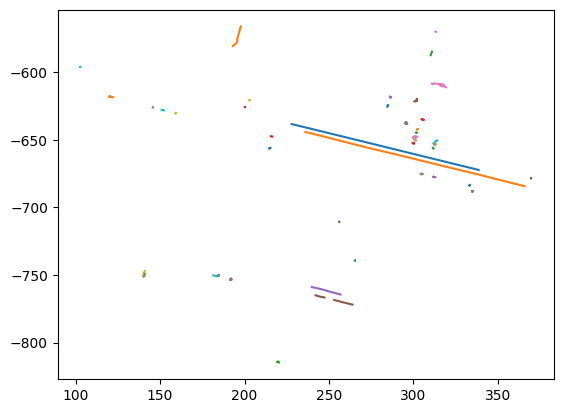

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )
        
        # print(f'x: {data_item.x.shape}')
        # print(f'y: {data_item.y.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [7]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    # 2 layers 9.77 val
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=60*2, num_layers=1):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x[..., :5]
        x = x.reshape(-1, 50, 50, 5)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [11]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [12]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=5, hidden_dim=512)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 8.946
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [13]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_67665/1407810273.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/100 [00:13<22:35, 13.69s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 0.1077 | Val MSE 0.0686 | Val MAE 1.1512 | Val MSE 3.3594
Sample pred first 3 steps: [[-0.00514298 -0.09610872]
 [-0.02376421 -0.08855839]
 [-0.00365807 -0.09264443]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.068559


Epoch:   2%|▏         | 2/100 [00:24<19:12, 11.76s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.0695 | Val MSE 0.0615 | Val MAE 1.0490 | Val MSE 3.0121
Validation improved: 0.068559 -> 0.061472


Epoch:   3%|▎         | 3/100 [00:34<17:50, 11.03s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.0683 | Val MSE 0.0625 | Val MAE 1.1340 | Val MSE 3.0633


Epoch:   4%|▍         | 4/100 [00:44<17:10, 10.73s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.0671 | Val MSE 0.0609 | Val MAE 1.0739 | Val MSE 2.9818
Validation improved: 0.061472 -> 0.060852


Epoch:   5%|▌         | 5/100 [00:54<16:46, 10.60s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.0671 | Val MSE 0.0625 | Val MAE 1.0730 | Val MSE 3.0614


Epoch:   6%|▌         | 6/100 [01:05<16:31, 10.55s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.0666 | Val MSE 0.0632 | Val MAE 1.1520 | Val MSE 3.0959
Sample pred first 3 steps: [[-0.06700241  0.10975808]
 [-0.06691141  0.10835707]
 [-0.06469026  0.10771792]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   7%|▋         | 7/100 [01:15<15:58, 10.31s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.0658 | Val MSE 0.0684 | Val MAE 1.2253 | Val MSE 3.3507


Epoch:   8%|▊         | 8/100 [01:24<15:29, 10.11s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.0655 | Val MSE 0.0641 | Val MAE 1.1159 | Val MSE 3.1398


Epoch:   9%|▉         | 9/100 [01:34<15:10, 10.00s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.0649 | Val MSE 0.0617 | Val MAE 1.0832 | Val MSE 3.0209


Epoch:  10%|█         | 10/100 [01:44<14:58,  9.98s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.0640 | Val MSE 0.0610 | Val MAE 1.0615 | Val MSE 2.9911


Epoch:  11%|█         | 11/100 [01:54<14:43,  9.92s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.0629 | Val MSE 0.0585 | Val MAE 1.0421 | Val MSE 2.8678
Sample pred first 3 steps: [[ 0.06268308 -0.05181016]
 [ 0.06294915 -0.04997196]
 [ 0.06296992 -0.04929425]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.060852 -> 0.058526


Epoch:  12%|█▏        | 12/100 [02:04<14:41, 10.01s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.2321 | Val MSE 0.1596 | Val MAE 1.9354 | Val MSE 7.8207


Epoch:  13%|█▎        | 13/100 [02:14<14:31, 10.02s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.0734 | Val MSE 0.0553 | Val MAE 1.0784 | Val MSE 2.7107
Validation improved: 0.058526 -> 0.055321


Epoch:  14%|█▍        | 14/100 [02:24<14:18,  9.99s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.0591 | Val MSE 0.0537 | Val MAE 1.0045 | Val MSE 2.6292
Validation improved: 0.055321 -> 0.053657


Epoch:  15%|█▌        | 15/100 [02:34<14:03,  9.93s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.0568 | Val MSE 0.0486 | Val MAE 0.9461 | Val MSE 2.3824
Validation improved: 0.053657 -> 0.048621


Epoch:  16%|█▌        | 16/100 [02:44<13:48,  9.86s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.0546 | Val MSE 0.0481 | Val MAE 0.9228 | Val MSE 2.3556
Sample pred first 3 steps: [[0.0034005  0.00150474]
 [0.00414987 0.00278685]
 [0.00471115 0.00474781]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.048621 -> 0.048074


Epoch:  17%|█▋        | 17/100 [02:54<13:46,  9.95s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.0537 | Val MSE 0.0481 | Val MAE 0.8902 | Val MSE 2.3563


Epoch:  18%|█▊        | 18/100 [03:04<13:52, 10.15s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.0526 | Val MSE 0.0482 | Val MAE 0.9393 | Val MSE 2.3634


Epoch:  19%|█▉        | 19/100 [03:14<13:36, 10.08s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.0516 | Val MSE 0.0444 | Val MAE 0.8545 | Val MSE 2.1742
Validation improved: 0.048074 -> 0.044372


Epoch:  20%|██        | 20/100 [03:24<13:17,  9.97s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.0508 | Val MSE 0.0473 | Val MAE 0.8913 | Val MSE 2.3188


Epoch:  21%|██        | 21/100 [03:34<13:07,  9.97s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.0500 | Val MSE 0.0447 | Val MAE 0.8586 | Val MSE 2.1918
Sample pred first 3 steps: [[-0.00716617 -0.05617255]
 [-0.00831582 -0.05793187]
 [-0.00934677 -0.06001088]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  22%|██▏       | 22/100 [03:44<12:51,  9.89s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.0491 | Val MSE 0.0419 | Val MAE 0.8090 | Val MSE 2.0519
Validation improved: 0.044372 -> 0.041875


Epoch:  23%|██▎       | 23/100 [03:53<12:39,  9.86s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.0489 | Val MSE 0.0460 | Val MAE 0.8726 | Val MSE 2.2548


Epoch:  24%|██▍       | 24/100 [04:03<12:35,  9.94s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.0478 | Val MSE 0.0415 | Val MAE 0.8485 | Val MSE 2.0349
Validation improved: 0.041875 -> 0.041529


Epoch:  25%|██▌       | 25/100 [04:14<12:28,  9.98s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.0472 | Val MSE 0.0426 | Val MAE 0.8539 | Val MSE 2.0851


Epoch:  26%|██▌       | 26/100 [04:24<12:20, 10.01s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.0468 | Val MSE 0.0411 | Val MAE 0.8088 | Val MSE 2.0142
Sample pred first 3 steps: [[-0.00220442  0.02827654]
 [-0.00135564  0.02994006]
 [-0.00073266  0.03098688]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.041529 -> 0.041105


Epoch:  27%|██▋       | 27/100 [04:34<12:19, 10.13s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.0459 | Val MSE 0.0403 | Val MAE 0.8114 | Val MSE 1.9760
Validation improved: 0.041105 -> 0.040327


Epoch:  28%|██▊       | 28/100 [04:44<12:00, 10.01s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.0456 | Val MSE 0.0417 | Val MAE 0.8472 | Val MSE 2.0414


Epoch:  29%|██▉       | 29/100 [04:54<11:44,  9.92s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.0457 | Val MSE 0.0403 | Val MAE 0.8039 | Val MSE 1.9764


Epoch:  30%|███       | 30/100 [05:04<11:42, 10.03s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.0450 | Val MSE 0.0403 | Val MAE 0.8081 | Val MSE 1.9761


Epoch:  31%|███       | 31/100 [05:13<11:25,  9.93s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.0444 | Val MSE 0.0397 | Val MAE 0.7895 | Val MSE 1.9471
Sample pred first 3 steps: [[-0.00941802 -0.03175136]
 [-0.01050772 -0.03080902]
 [-0.01207959 -0.02997169]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.040327 -> 0.039737


Epoch:  32%|███▏      | 32/100 [05:23<11:13,  9.91s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.0441 | Val MSE 0.0389 | Val MAE 0.7542 | Val MSE 1.9083
Validation improved: 0.039737 -> 0.038944


Epoch:  33%|███▎      | 33/100 [05:33<11:00,  9.86s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.0435 | Val MSE 0.0395 | Val MAE 0.7908 | Val MSE 1.9359


Epoch:  34%|███▍      | 34/100 [05:43<10:51,  9.86s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.0433 | Val MSE 0.0386 | Val MAE 0.7851 | Val MSE 1.8904
Validation improved: 0.038944 -> 0.038579


Epoch:  35%|███▌      | 35/100 [05:53<10:40,  9.86s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.0427 | Val MSE 0.0382 | Val MAE 0.7514 | Val MSE 1.8734
Validation improved: 0.038579 -> 0.038233


Epoch:  36%|███▌      | 36/100 [06:03<10:37,  9.96s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.0421 | Val MSE 0.0383 | Val MAE 0.7704 | Val MSE 1.8749
Sample pred first 3 steps: [[0.00023688 0.01063714]
 [0.00030621 0.01083882]
 [0.00032482 0.01131372]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  37%|███▋      | 37/100 [06:13<10:27,  9.96s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.0415 | Val MSE 0.0385 | Val MAE 0.7945 | Val MSE 1.8874


Epoch:  38%|███▊      | 38/100 [06:23<10:15,  9.93s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.0418 | Val MSE 0.0387 | Val MAE 0.7866 | Val MSE 1.8943


Epoch:  39%|███▉      | 39/100 [06:32<09:58,  9.82s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.0416 | Val MSE 0.0398 | Val MAE 0.7983 | Val MSE 1.9504


Epoch:  40%|████      | 40/100 [06:42<09:46,  9.78s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.0411 | Val MSE 0.0383 | Val MAE 0.7800 | Val MSE 1.8749


Epoch:  41%|████      | 41/100 [06:52<09:41,  9.86s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.0414 | Val MSE 0.0391 | Val MAE 0.7991 | Val MSE 1.9166
Sample pred first 3 steps: [[0.00211625 0.01501404]
 [0.00359419 0.01577694]
 [0.00568091 0.01581305]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  42%|████▏     | 42/100 [07:02<09:31,  9.85s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.0407 | Val MSE 0.0377 | Val MAE 0.7651 | Val MSE 1.8492
Validation improved: 0.038233 -> 0.037738


Epoch:  43%|████▎     | 43/100 [07:12<09:24,  9.91s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.0408 | Val MSE 0.0379 | Val MAE 0.7797 | Val MSE 1.8583


Epoch:  44%|████▍     | 44/100 [07:22<09:12,  9.86s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.0404 | Val MSE 0.0380 | Val MAE 0.7643 | Val MSE 1.8605


Epoch:  45%|████▌     | 45/100 [07:31<08:58,  9.79s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.0406 | Val MSE 0.0374 | Val MAE 0.7643 | Val MSE 1.8335
Validation improved: 0.037738 -> 0.037418


Epoch:  46%|████▌     | 46/100 [07:41<08:46,  9.75s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.0400 | Val MSE 0.0380 | Val MAE 0.7696 | Val MSE 1.8622
Sample pred first 3 steps: [[-0.00749255 -0.02655148]
 [-0.00979151 -0.02615742]
 [-0.011698   -0.02544789]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  47%|████▋     | 47/100 [07:51<08:34,  9.70s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.0398 | Val MSE 0.0373 | Val MAE 0.7636 | Val MSE 1.8278
Validation improved: 0.037418 -> 0.037302


Epoch:  48%|████▊     | 48/100 [08:01<08:28,  9.77s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.0396 | Val MSE 0.0370 | Val MAE 0.7667 | Val MSE 1.8127
Validation improved: 0.037302 -> 0.036993


Epoch:  49%|████▉     | 49/100 [08:10<08:10,  9.62s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.0397 | Val MSE 0.0365 | Val MAE 0.7402 | Val MSE 1.7872
Validation improved: 0.036993 -> 0.036474


Epoch:  50%|█████     | 50/100 [08:18<07:38,  9.16s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.0395 | Val MSE 0.0363 | Val MAE 0.7473 | Val MSE 1.7768
Validation improved: 0.036474 -> 0.036260


Epoch:  51%|█████     | 51/100 [08:26<07:12,  8.82s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.0391 | Val MSE 0.0368 | Val MAE 0.7461 | Val MSE 1.8026
Sample pred first 3 steps: [[-0.01916283 -0.01451803]
 [-0.02006391 -0.01469921]
 [-0.02084491 -0.01500687]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  52%|█████▏    | 52/100 [08:34<06:54,  8.64s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.0390 | Val MSE 0.0367 | Val MAE 0.7386 | Val MSE 1.7972


Epoch:  53%|█████▎    | 53/100 [08:42<06:36,  8.44s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.0390 | Val MSE 0.0369 | Val MAE 0.7601 | Val MSE 1.8098


Epoch:  54%|█████▍    | 54/100 [08:50<06:22,  8.31s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.0390 | Val MSE 0.0363 | Val MAE 0.7317 | Val MSE 1.7777


Epoch:  55%|█████▌    | 55/100 [08:58<06:10,  8.23s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.0385 | Val MSE 0.0358 | Val MAE 0.7213 | Val MSE 1.7562
Validation improved: 0.036260 -> 0.035840


Epoch:  56%|█████▌    | 56/100 [09:07<06:03,  8.26s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.0385 | Val MSE 0.0359 | Val MAE 0.7429 | Val MSE 1.7601
Sample pred first 3 steps: [[-0.00703293 -0.02361749]
 [-0.00715114 -0.02324006]
 [-0.00660661 -0.02250613]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  57%|█████▋    | 57/100 [09:14<05:50,  8.15s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.0380 | Val MSE 0.0362 | Val MAE 0.7369 | Val MSE 1.7730


Epoch:  58%|█████▊    | 58/100 [09:22<05:39,  8.08s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.0378 | Val MSE 0.0363 | Val MAE 0.7489 | Val MSE 1.7765


Epoch:  59%|█████▉    | 59/100 [09:30<05:28,  8.01s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.0381 | Val MSE 0.0358 | Val MAE 0.7468 | Val MSE 1.7551
Validation improved: 0.035840 -> 0.035818


Epoch:  60%|██████    | 60/100 [09:38<05:21,  8.03s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.0378 | Val MSE 0.0364 | Val MAE 0.7471 | Val MSE 1.7852


Epoch:  61%|██████    | 61/100 [09:46<05:12,  8.02s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.0376 | Val MSE 0.0355 | Val MAE 0.7315 | Val MSE 1.7411
Sample pred first 3 steps: [[0.02292503 0.0040341 ]
 [0.02253767 0.00437547]
 [0.02197639 0.00499437]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035818 -> 0.035532


Epoch:  62%|██████▏   | 62/100 [09:54<05:06,  8.06s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.0376 | Val MSE 0.0360 | Val MAE 0.7382 | Val MSE 1.7623


Epoch:  63%|██████▎   | 63/100 [10:02<04:58,  8.08s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.0378 | Val MSE 0.0355 | Val MAE 0.7257 | Val MSE 1.7383
Validation improved: 0.035532 -> 0.035476


Epoch:  64%|██████▍   | 64/100 [10:11<04:54,  8.19s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.0376 | Val MSE 0.0361 | Val MAE 0.7452 | Val MSE 1.7680


Epoch:  65%|██████▌   | 65/100 [10:19<04:44,  8.12s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.0375 | Val MSE 0.0360 | Val MAE 0.7370 | Val MSE 1.7622


Epoch:  66%|██████▌   | 66/100 [10:27<04:34,  8.08s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.0373 | Val MSE 0.0354 | Val MAE 0.7218 | Val MSE 1.7354
Sample pred first 3 steps: [[0.00407748 0.00686108]
 [0.00285171 0.00645392]
 [0.00146467 0.00620085]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035476 -> 0.035417


Epoch:  67%|██████▋   | 67/100 [10:35<04:27,  8.11s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.0372 | Val MSE 0.0354 | Val MAE 0.7239 | Val MSE 1.7356


Epoch:  68%|██████▊   | 68/100 [10:43<04:18,  8.07s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.0373 | Val MSE 0.0355 | Val MAE 0.7298 | Val MSE 1.7418


Epoch:  69%|██████▉   | 69/100 [10:51<04:10,  8.08s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.0372 | Val MSE 0.0354 | Val MAE 0.7123 | Val MSE 1.7326
Validation improved: 0.035417 -> 0.035360


Epoch:  70%|███████   | 70/100 [10:59<04:02,  8.07s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.0370 | Val MSE 0.0353 | Val MAE 0.7149 | Val MSE 1.7283
Validation improved: 0.035360 -> 0.035272


Epoch:  71%|███████   | 71/100 [11:08<03:57,  8.20s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.0369 | Val MSE 0.0356 | Val MAE 0.7361 | Val MSE 1.7456
Sample pred first 3 steps: [[ 0.00218357 -0.00170863]
 [ 0.00047284 -0.00032594]
 [-0.0012302   0.00143228]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  72%|███████▏  | 72/100 [11:16<03:48,  8.17s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.0368 | Val MSE 0.0356 | Val MAE 0.7246 | Val MSE 1.7467


Epoch:  73%|███████▎  | 73/100 [11:24<03:38,  8.11s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.0365 | Val MSE 0.0356 | Val MAE 0.7296 | Val MSE 1.7454


Epoch:  74%|███████▍  | 74/100 [11:32<03:29,  8.05s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.0369 | Val MSE 0.0355 | Val MAE 0.7292 | Val MSE 1.7378


Epoch:  75%|███████▌  | 75/100 [11:40<03:20,  8.03s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.0368 | Val MSE 0.0353 | Val MAE 0.7272 | Val MSE 1.7305


Epoch:  76%|███████▌  | 76/100 [11:48<03:12,  8.03s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.0369 | Val MSE 0.0354 | Val MAE 0.7171 | Val MSE 1.7363
Sample pred first 3 steps: [[-0.00167398  0.00184491]
 [-0.00261942  0.00221661]
 [-0.00400147  0.00225315]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  77%|███████▋  | 77/100 [11:56<03:04,  8.02s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.0362 | Val MSE 0.0352 | Val MAE 0.7210 | Val MSE 1.7250
Validation improved: 0.035272 -> 0.035204


Epoch:  78%|███████▊  | 78/100 [12:04<02:58,  8.14s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.0365 | Val MSE 0.0355 | Val MAE 0.7272 | Val MSE 1.7396


Epoch:  79%|███████▉  | 79/100 [12:12<02:52,  8.19s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.0367 | Val MSE 0.0356 | Val MAE 0.7283 | Val MSE 1.7427


Epoch:  80%|████████  | 80/100 [12:20<02:43,  8.16s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.0364 | Val MSE 0.0353 | Val MAE 0.7235 | Val MSE 1.7280


Epoch:  81%|████████  | 81/100 [12:29<02:34,  8.12s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.0362 | Val MSE 0.0351 | Val MAE 0.7320 | Val MSE 1.7210
Sample pred first 3 steps: [[0.01410558 0.00245077]
 [0.01459678 0.00348076]
 [0.01519238 0.00449156]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.035204 -> 0.035123


Epoch:  82%|████████▏ | 82/100 [12:37<02:27,  8.17s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.0366 | Val MSE 0.0358 | Val MAE 0.7318 | Val MSE 1.7532


Epoch:  83%|████████▎ | 83/100 [12:45<02:18,  8.17s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.0363 | Val MSE 0.0350 | Val MAE 0.7188 | Val MSE 1.7163
Validation improved: 0.035123 -> 0.035026


Epoch:  84%|████████▍ | 84/100 [12:53<02:10,  8.17s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.0364 | Val MSE 0.0350 | Val MAE 0.7203 | Val MSE 1.7166


Epoch:  85%|████████▌ | 85/100 [13:01<02:01,  8.13s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.0364 | Val MSE 0.0350 | Val MAE 0.7161 | Val MSE 1.7137
Validation improved: 0.035026 -> 0.034973


Epoch:  86%|████████▌ | 86/100 [13:10<01:57,  8.38s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.0359 | Val MSE 0.0350 | Val MAE 0.7145 | Val MSE 1.7142
Sample pred first 3 steps: [[ 0.0018123  -0.0009904 ]
 [ 0.00138158 -0.00032838]
 [ 0.00103906  0.00052162]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  87%|████████▋ | 87/100 [13:18<01:47,  8.28s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.0360 | Val MSE 0.0351 | Val MAE 0.7215 | Val MSE 1.7212


Epoch:  88%|████████▊ | 88/100 [13:26<01:38,  8.19s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.0362 | Val MSE 0.0348 | Val MAE 0.7094 | Val MSE 1.7031
Validation improved: 0.034973 -> 0.034757


Epoch:  89%|████████▉ | 89/100 [13:34<01:29,  8.14s/epoch]

Epoch 088 | LR 0.000073 | Train MSE 0.0363 | Val MSE 0.0351 | Val MAE 0.7173 | Val MSE 1.7208


Epoch:  90%|█████████ | 90/100 [13:42<01:21,  8.12s/epoch]

Epoch 089 | LR 0.000069 | Train MSE 0.0363 | Val MSE 0.0351 | Val MAE 0.7131 | Val MSE 1.7210


Epoch:  91%|█████████ | 91/100 [13:50<01:12,  8.08s/epoch]

Epoch 090 | LR 0.000066 | Train MSE 0.0363 | Val MSE 0.0349 | Val MAE 0.7051 | Val MSE 1.7098
Sample pred first 3 steps: [[ 0.0023164  -0.00164072]
 [ 0.0014302  -0.00148197]
 [ 0.00078484 -0.00105085]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  92%|█████████▏| 92/100 [13:58<01:04,  8.05s/epoch]

Epoch 091 | LR 0.000062 | Train MSE 0.0363 | Val MSE 0.0351 | Val MAE 0.7154 | Val MSE 1.7200


Epoch:  93%|█████████▎| 93/100 [14:07<00:58,  8.31s/epoch]

Epoch 092 | LR 0.000059 | Train MSE 0.0361 | Val MSE 0.0351 | Val MAE 0.7197 | Val MSE 1.7183


Epoch:  94%|█████████▍| 94/100 [14:15<00:49,  8.30s/epoch]

Epoch 093 | LR 0.000056 | Train MSE 0.0362 | Val MSE 0.0352 | Val MAE 0.7186 | Val MSE 1.7242


Epoch:  95%|█████████▌| 95/100 [14:24<00:41,  8.29s/epoch]

Epoch 094 | LR 0.000054 | Train MSE 0.0362 | Val MSE 0.0352 | Val MAE 0.7188 | Val MSE 1.7255


Epoch:  96%|█████████▌| 96/100 [14:32<00:33,  8.33s/epoch]

Epoch 095 | LR 0.000051 | Train MSE 0.0358 | Val MSE 0.0349 | Val MAE 0.7128 | Val MSE 1.7116
Sample pred first 3 steps: [[-0.00264229  0.00108819]
 [-0.00308352  0.00147185]
 [-0.00359434  0.00212132]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  97%|█████████▋| 97/100 [14:40<00:24,  8.24s/epoch]

Epoch 096 | LR 0.000048 | Train MSE 0.0361 | Val MSE 0.0350 | Val MAE 0.7147 | Val MSE 1.7147


Epoch:  98%|█████████▊| 98/100 [14:48<00:16,  8.21s/epoch]

Epoch 097 | LR 0.000046 | Train MSE 0.0360 | Val MSE 0.0349 | Val MAE 0.7127 | Val MSE 1.7108


Epoch:  99%|█████████▉| 99/100 [14:56<00:08,  8.18s/epoch]

Epoch 098 | LR 0.000044 | Train MSE 0.0358 | Val MSE 0.0350 | Val MAE 0.7112 | Val MSE 1.7138


Epoch: 100%|██████████| 100/100 [15:05<00:00,  9.05s/epoch]


Epoch 099 | LR 0.000041 | Train MSE 0.0359 | Val MSE 0.0349 | Val MAE 0.7117 | Val MSE 1.7083
Val MSE: 1.7031


SimpleLSTM(
  (lstm): LSTM(5, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

# Final Pred

In [15]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto8.csv', index=True)